## 1. Create a Image Hash.

### Idea from https://github.com/mendesk/image-ndd-lsh

In [462]:
!python3 -m pip install imagehash Image

In [463]:
import imagehash
from PIL import Image
import numpy as np

Article -> https://pypi.org/project/ImageHash/
dhash -> difference hash

In [464]:
def calculate_signature(image_file: str, hash_size: int) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [465]:
def calculate_signature_np(image_file: np.array, hash_size: int) -> np.ndarray:
    pil_image = Image.fromarray(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.BILINEAR)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

## 2. Create LSH algorithm

### 2.1 Get the dataset

In [466]:
#!apt-get install wget
#!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [467]:
#!tar -xvzf cifar-10-python.tar.gz

In [468]:
#!rm -rf cifar-10-python.tar.gz
#!mv cifar-10-batches-py ../data

### 2.2 Read the files

In [469]:
import os
import _pickle as cPickle

In [470]:
PATH = "../data/cifar-10-batches-py/"

#### 2.2.1 Load Cifar-10

In [471]:
def load_batch():
    file = 'data_batch_1'

    f = open(PATH+file, 'rb')
    dict = cPickle.load(f, encoding='latin1')
    images = dict['data']
    #images = np.reshape(images, (10000, 3, 32, 32))
    labels = dict['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

In [472]:
def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

label_names = load_classes()
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


In [473]:
images, labels = load_batch()

In [474]:
labels.shape

(10000,)

In [475]:
image = np.reshape(images[0], (3, 32, 32))

In [476]:
image.shape

(3, 32, 32)

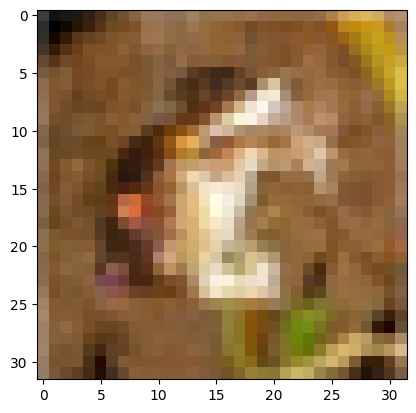

In [477]:
from matplotlib import pyplot as plt
plt.imshow(image.T, interpolation='nearest')
plt.show()

In [478]:
print(label_names[labels[0]])

frog


In [479]:
calculate_signature_np(image.T, 8)

array([ True,  True,  True, False, False,  True,  True,  True,  True,
        True, False, False,  True, False, False,  True, False, False,
        True,  True,  True, False, False, False, False, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False, False,  True, False, False,  True,  True, False,
       False, False, False, False, False,  True,  True, False, False,
        True, False, False,  True,  True,  True, False,  True, False,
       False])

### 2.2.2 Algorithm

In [481]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):  # shingels
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np(image.T, self.hash_size)
            self.signatures[idx] = np.packbits(signature.astype(np.uint8))
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            
    

In [482]:
images = images.reshape(10000,3,32,32)
images.shape

(10000, 3, 32, 32)

In [484]:
import time

start = time.time()

lsh = LSH(8, 8)
shingels = lsh.compute_hash(images)
pairs = lsh.compute_candidate()
duplicates = lsh.check_candidate(pairs,0.70)

end = time.time()
print( "time: ", end - start )

time:  33.93551516532898


In [485]:
print(len(pairs))
print(len(lsh.buckets))

2466583
8


0


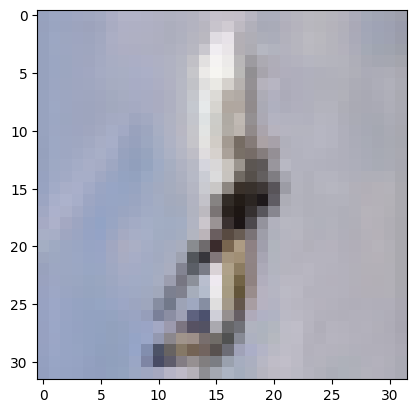

In [319]:
print(labels[264])
plt.imshow(images[264].reshape(3,32,32).T, interpolation='nearest')
plt.show()

0


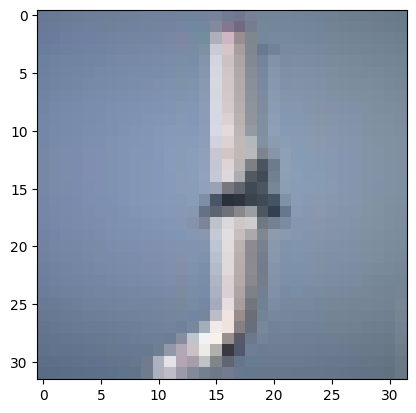

In [320]:
print(labels[7663])
plt.imshow(images[7663].reshape(3,32,32).T, interpolation='nearest')
plt.show()

dhash is a Python library that generates a "difference hash" for a given image -- 
a perceptual hash based on Neal Krawetz's dHash algorithm in this "Hacker Factor" blog entry.

I've found that dhash is great for detecting near duplicates (we found dupes using a size 8 dhash with a maximum delta of 2 bits). But because of the simplicity of the algorithm, it's not great at finding similar images or duplicate-but-cropped images -- you'd need a more sophisticated image fingerprint if you want that. However, the dhash is good for finding exact duplicates and near duplicates, for example, the same image with slightly altered lighting, a few pixels of cropping, or very light photoshopping.

The library defaults to producing a size 8 dhash, but you can override this easily by passing size=N as a keyword argument to most functions. For example, you can produce a more accurate (but slower to work with) dhash of 512 bits by specifying size=16.


### LSH with MinHash POC

In [128]:
def build_vocab(hash_size):
    vocab = []
    for i in range(hash_size**2):
        vocab.append(i)
    return vocab

In [129]:
import random 
def create_minhash_hashlists(vocab_size: int, n=20):
  hashlist = []
  for i in range(n):
    arr = list(range(1, vocab_size+1))
    random.shuffle(arr)
    hashlist.append(arr.copy())
  return hashlist

In [141]:
def minhash_gpu(onehots: np.array, hashlists, bs=50):
    h = np.array(hashlists)
    sigidx = np.zeros((h.shape[0], onehots.shape[0]))

    # fix zeros on arr resulting in 0 after multiplication
    n = onehots.shape[0]
    t_h = torch.from_numpy(h).cuda()
    for i in range(0, onehots.shape[0], bs):
        s = slice(i, min(i+bs, n))
        t_onehots = torch.from_numpy(onehots[s]).cuda()

        arr = torch.einsum('ij,kj->ikj', t_h, t_onehots)
        arr[arr == 0] = 2**63-1
        # sigidx is uniformally distributed, thereby used as hash
        sigidx[:,s] = arr.argmin(axis=2).cpu()

    return sigidx

In [142]:
vocab = build_vocab(16)
len(vocab)

256

In [143]:
hashlists = create_minhash_hashlists(len(vocab))
len(hashlists)

20

In [144]:
def gethot(tokens, vocab):
    return [1 if x in tokens else 0 for x in vocab]

In [145]:
print( len(shingels) )
print( shingels[0].shape )
print( shingels[0] )

10000
(32,)
[122  30 248  23 232 243  57 203 123 193 103 147  14 145  15  25  55  11
  31  22  14   5  15  12 103  12  23  52  27  61  62 177]


In [146]:
a1hot = gethot(shingels[0], vocab)
b1hot = gethot(shingels[1], vocab)
c1hot = gethot(shingels[2], vocab)
d1hot = gethot(shingels[5119], vocab)
e1hot = gethot(shingels[9967], vocab)

In [147]:
import torch

In [148]:
print( len(a1hot) )
print( len([a1hot, b1hot, c1hot,d1hot,e1hot]) )
print( np.array([a1hot, b1hot, c1hot,d1hot,e1hot]).shape )
sigs = minhash_gpu(np.array([a1hot, b1hot, c1hot,d1hot,e1hot]), hashlists)

256
5
(5, 256)


In [149]:
def unstack(a, axis=0):
  return np.moveaxis(a, axis, 0)

In [150]:
print(sigs.shape)
print(sigs)

(20, 5)
[[203. 151. 124. 124. 160.]
 [ 55. 206. 203.  79. 160.]
 [ 23. 206.   1. 192. 192.]
 [243.  44. 124.  44. 192.]
 [ 15.  46.  15.  60.  60.]
 [ 14. 101.  14.   0.   0.]
 [  5. 139.  38. 250.  12.]
 [ 57. 151.  38.  28.  28.]
 [ 23.  10. 130.   0. 223.]
 [ 14. 111.  14.   0.   0.]
 [147.   6. 129. 143.  47.]
 [ 30. 170.   3.  30.  30.]
 [177. 250.  27. 250.  50.]
 [177.  72.  70.  28.  28.]
 [ 25. 170. 124. 143. 143.]
 [203. 247. 128. 128.  12.]
 [203. 203. 203.  15. 223.]
 [ 31.  12.  31.  95.  95.]
 [ 27.   7. 130. 240. 240.]
 [145.   7.  15.  15.  56.]]


In [151]:
asig, bsig, csig, dsig, esig = unstack(sigs, axis=1)

In [152]:
print(esig)
print(asig) 

[160. 160. 192. 192.  60.   0.  12.  28. 223.   0.  47.  30.  50.  28.
 143.  12. 223.  95. 240.  56.]
[203.  55.  23. 243.  15.  14.   5.  57.  23.  14. 147.  30. 177. 177.
  25. 203. 203.  31.  27. 145.]


In [155]:
from itertools import combinations

class LSH2:
    def __init__(self, b):
        self.b = b
        # buckets maps between matching sig fragments and IDs
        # A whole list should be inserted as-is so its indexes match the bucket IDs
        self.buckets = []
        self.counter = 0
        for i in range(b):
            self.buckets.append({})

    def add_hashes(self, sigs):
        if isinstance(sigs, list):
            sigs = np.array(sigs).T

        subvecs = self.split_vec(sigs).astype('str')
        tmp = np.char.add(subvecs[:,0], ',')
        subvecs = np.char.add(tmp, subvecs[:,1])
        for sig_subvecs in subvecs.T:
            for i, subvec in enumerate(sig_subvecs):
                if subvec not in self.buckets[i].keys():
                    self.buckets[i][subvec] = []
                self.buckets[i][subvec].append(self.counter)
            self.counter += 1

    def split_vec(self, sigs):
        if isinstance(sigs, list):
            sigs = np.array(sigs).T

        sig_len, sigs_num = np.shape(sigs)
        assert(self.b < sig_len)
        assert((np.any(sig_len % self.b) != 0) == False)

        return np.array(np.array_split(sigs, self.b, axis=0))

    def check_candidates(self):
        candidates = []
        print(len(self.buckets))
        for band in self.buckets:
            for keys, hits in band.items():
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))

        return set(candidates)

lsh2 = LSH2(5)
lsh2.add_hashes([asig,asig, bsig, csig, dsig, esig])
lsh2.buckets

[{'203.0,55.0': [0, 1],
  '151.0,206.0': [2],
  '124.0,203.0': [3],
  '124.0,79.0': [4],
  '160.0,160.0': [5]},
 {'15.0,14.0': [0, 1, 3], '46.0,101.0': [2], '60.0,0.0': [4, 5]},
 {'23.0,14.0': [0, 1],
  '10.0,111.0': [2],
  '130.0,14.0': [3],
  '0.0,0.0': [4],
  '223.0,0.0': [5]},
 {'177.0,177.0': [0, 1],
  '250.0,72.0': [2],
  '27.0,70.0': [3],
  '250.0,28.0': [4],
  '50.0,28.0': [5]},
 {'203.0,31.0': [0, 1, 3],
  '203.0,12.0': [2],
  '15.0,95.0': [4],
  '223.0,95.0': [5]}]

In [156]:
candidates2 = list(lsh2.check_candidates())
print(candidates2)

5
[(0, 1), (4, 5), (0, 3), (1, 3)]


#### Prepare images

In [224]:
import time

start = time.time()

lsh = LSH(16, 16)
shingels = lsh.compute_hash(images)

vocab = build_vocab(16)
hashlists = create_minhash_hashlists(len(vocab), 40)

n_hots = []
for i in range (0, len(shingels)):
    n_hots.append(gethot(shingels[i], vocab))

print(np.array(n_hots).shape)
sigs = minhash_gpu(np.array(n_hots), hashlists)
#sigs2 = np.moveaxis(sigs, 1, 0)

lsh2 = LSH2(5)
lsh2.add_hashes(sigs)

candidate_pairs = list(lsh2.check_candidates())
print(len(candidate_pairs))
end = time.time()
print( "time: ", end - start )

(10000, 256)
5
2317699
time:  11.347894191741943


In [225]:
print(candidate_pairs[0:100])

[(2403, 6059), (1004, 6613), (3764, 8431), (4177, 4628), (2057, 4668), (2544, 4786), (2492, 4596), (5045, 9319), (2580, 6695), (897, 1828), (594, 2019), (1836, 9395), (7128, 8643), (2338, 4129), (2183, 7224), (4260, 5602), (831, 3460), (3442, 9319), (3134, 5002), (1205, 9528), (3509, 4125), (4252, 8370), (6122, 9653), (771, 6038), (4467, 6080), (4996, 9053), (6718, 7432), (2503, 5135), (5586, 5886), (4032, 9535), (3776, 5408), (3569, 8313), (3944, 7436), (1759, 7835), (986, 7131), (2760, 5700), (1884, 8281), (5277, 8514), (7949, 8233), (5492, 6224), (7897, 8043), (1003, 1850), (165, 1505), (1479, 8195), (3776, 8791), (4402, 7533), (4955, 6019), (818, 8486), (1283, 4873), (5933, 7098), (5212, 6584), (2349, 8051), (3837, 6034), (9437, 9599), (843, 3820), (2718, 9611), (807, 1911), (2837, 4607), (2336, 6311), (2284, 6121), (7038, 8726), (1152, 4575), (2771, 6239), (4170, 5685), (2926, 3144), (6022, 9018), (8371, 9804), (468, 8080), (3300, 9212), (5545, 9618), (1860, 3349), (1278, 7131), (

In [174]:
#lsh2.buckets

0


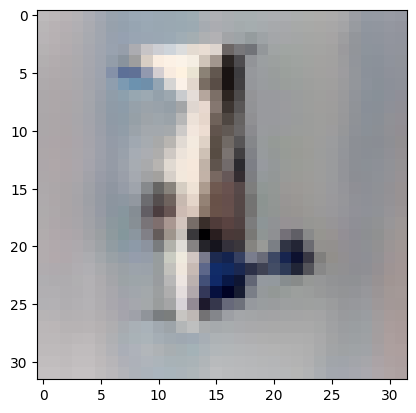

In [226]:
print(labels[2403])
plt.imshow(images[2403].reshape(3,32,32).T, interpolation='nearest')
plt.show()

7


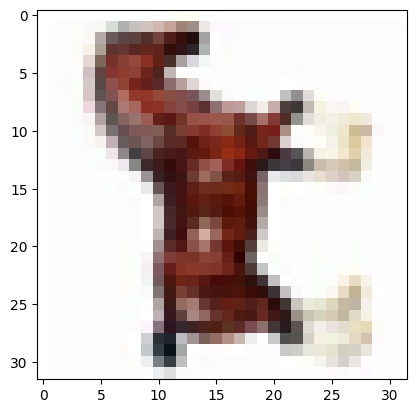

In [227]:
print(labels[6059])
plt.imshow(images[6059].reshape(3,32,32).T, interpolation='nearest')
plt.show()

In [188]:
!pip install scikit-learn
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 2.7 MB/s eta 0:00:00a 0:00:01


In [34]:
fig = plt.figure()
plt.imshow(grad, cmap='gray')

NameError: name 'grad' is not defined

<Figure size 640x480 with 0 Axes>

In [445]:
import torch 
import torchvision

def convolve(img, weights, hash_size, padding_size = 0):
    tensor_image = torch.reshape(img,(1,1,hash_size, hash_size))
    conv_img = torch.nn.functional.conv2d(tensor_image, weights, padding=int(padding_size))
    conv_img = conv_img.squeeze(0)
    conv_img = torch.permute(conv_img, (1,2,0))
    return conv_img

def gauss_kernel(size, sig=1.):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    res = kernel / np.sum(kernel)
    return torch.DoubleTensor(res.reshape(1,1,size,size))

def sobel_filters(img):
    
    Kx = torch.DoubleTensor([[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]])
    Ky = torch.DoubleTensor([[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]])
    
    img = img.unsqueeze(0)
    img = torch.permute(img, (0,3,1,2))

    Ix = torch.nn.functional.conv2d(img, Kx.unsqueeze(0))
    Iy = torch.nn.functional.conv2d(img, Ky.unsqueeze(0))
    
    return Ix, Iy

def relu(grad, _min):
    return torch.where(grad > _min, grad, 0.)

def calculate_signature_np_only_edges(image_file: np.array, hash_size: int):
    pil_image = Image.fromarray(image_file).convert("L")

    size = 5
    kernel = gauss_kernel(size)
    origin_image_size = 32

    np_image = np.array(pil_image).astype(np.float64)
    tensor_image = torch.tensor(np_image)

    image_blurred = convolve(tensor_image, kernel, origin_image_size, int(np.sqrt(size)))

    sobels = sobel_filters(image_blurred)
    gradient = np.sqrt(sobels[0]**2 + sobels[1]**2) 

    grad = relu(gradient, 0.5)
    grad = grad.squeeze(0)
    
    pil_image = torchvision.transforms.functional.to_pil_image(grad.to(torch.int32))
    pil_image.resize((hash_size+1, hash_size),Image.BILINEAR)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()

    return signature
    #return pil_image
    #return grad


In [446]:
img_hash = calculate_signature_np_only_edges(images[5834].T, 32)
img_hash

array([False, False, False, ..., False,  True,  True])

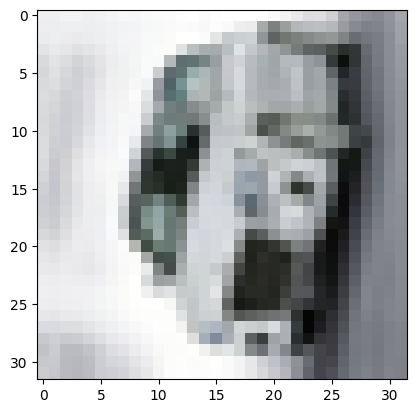

In [422]:
fig = plt.figure()
plt.imshow(images[7774].T, cmap='gray')

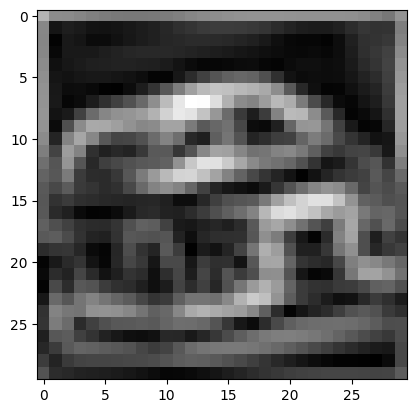

In [280]:
fig = plt.figure()
plt.imshow(img_hash.T, cmap='gray')

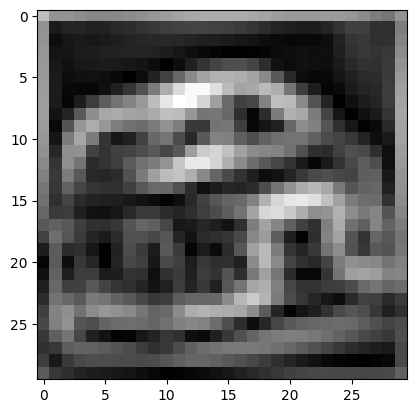

In [282]:
fig = plt.figure()
plt.imshow(img_hash.T, cmap='gray')

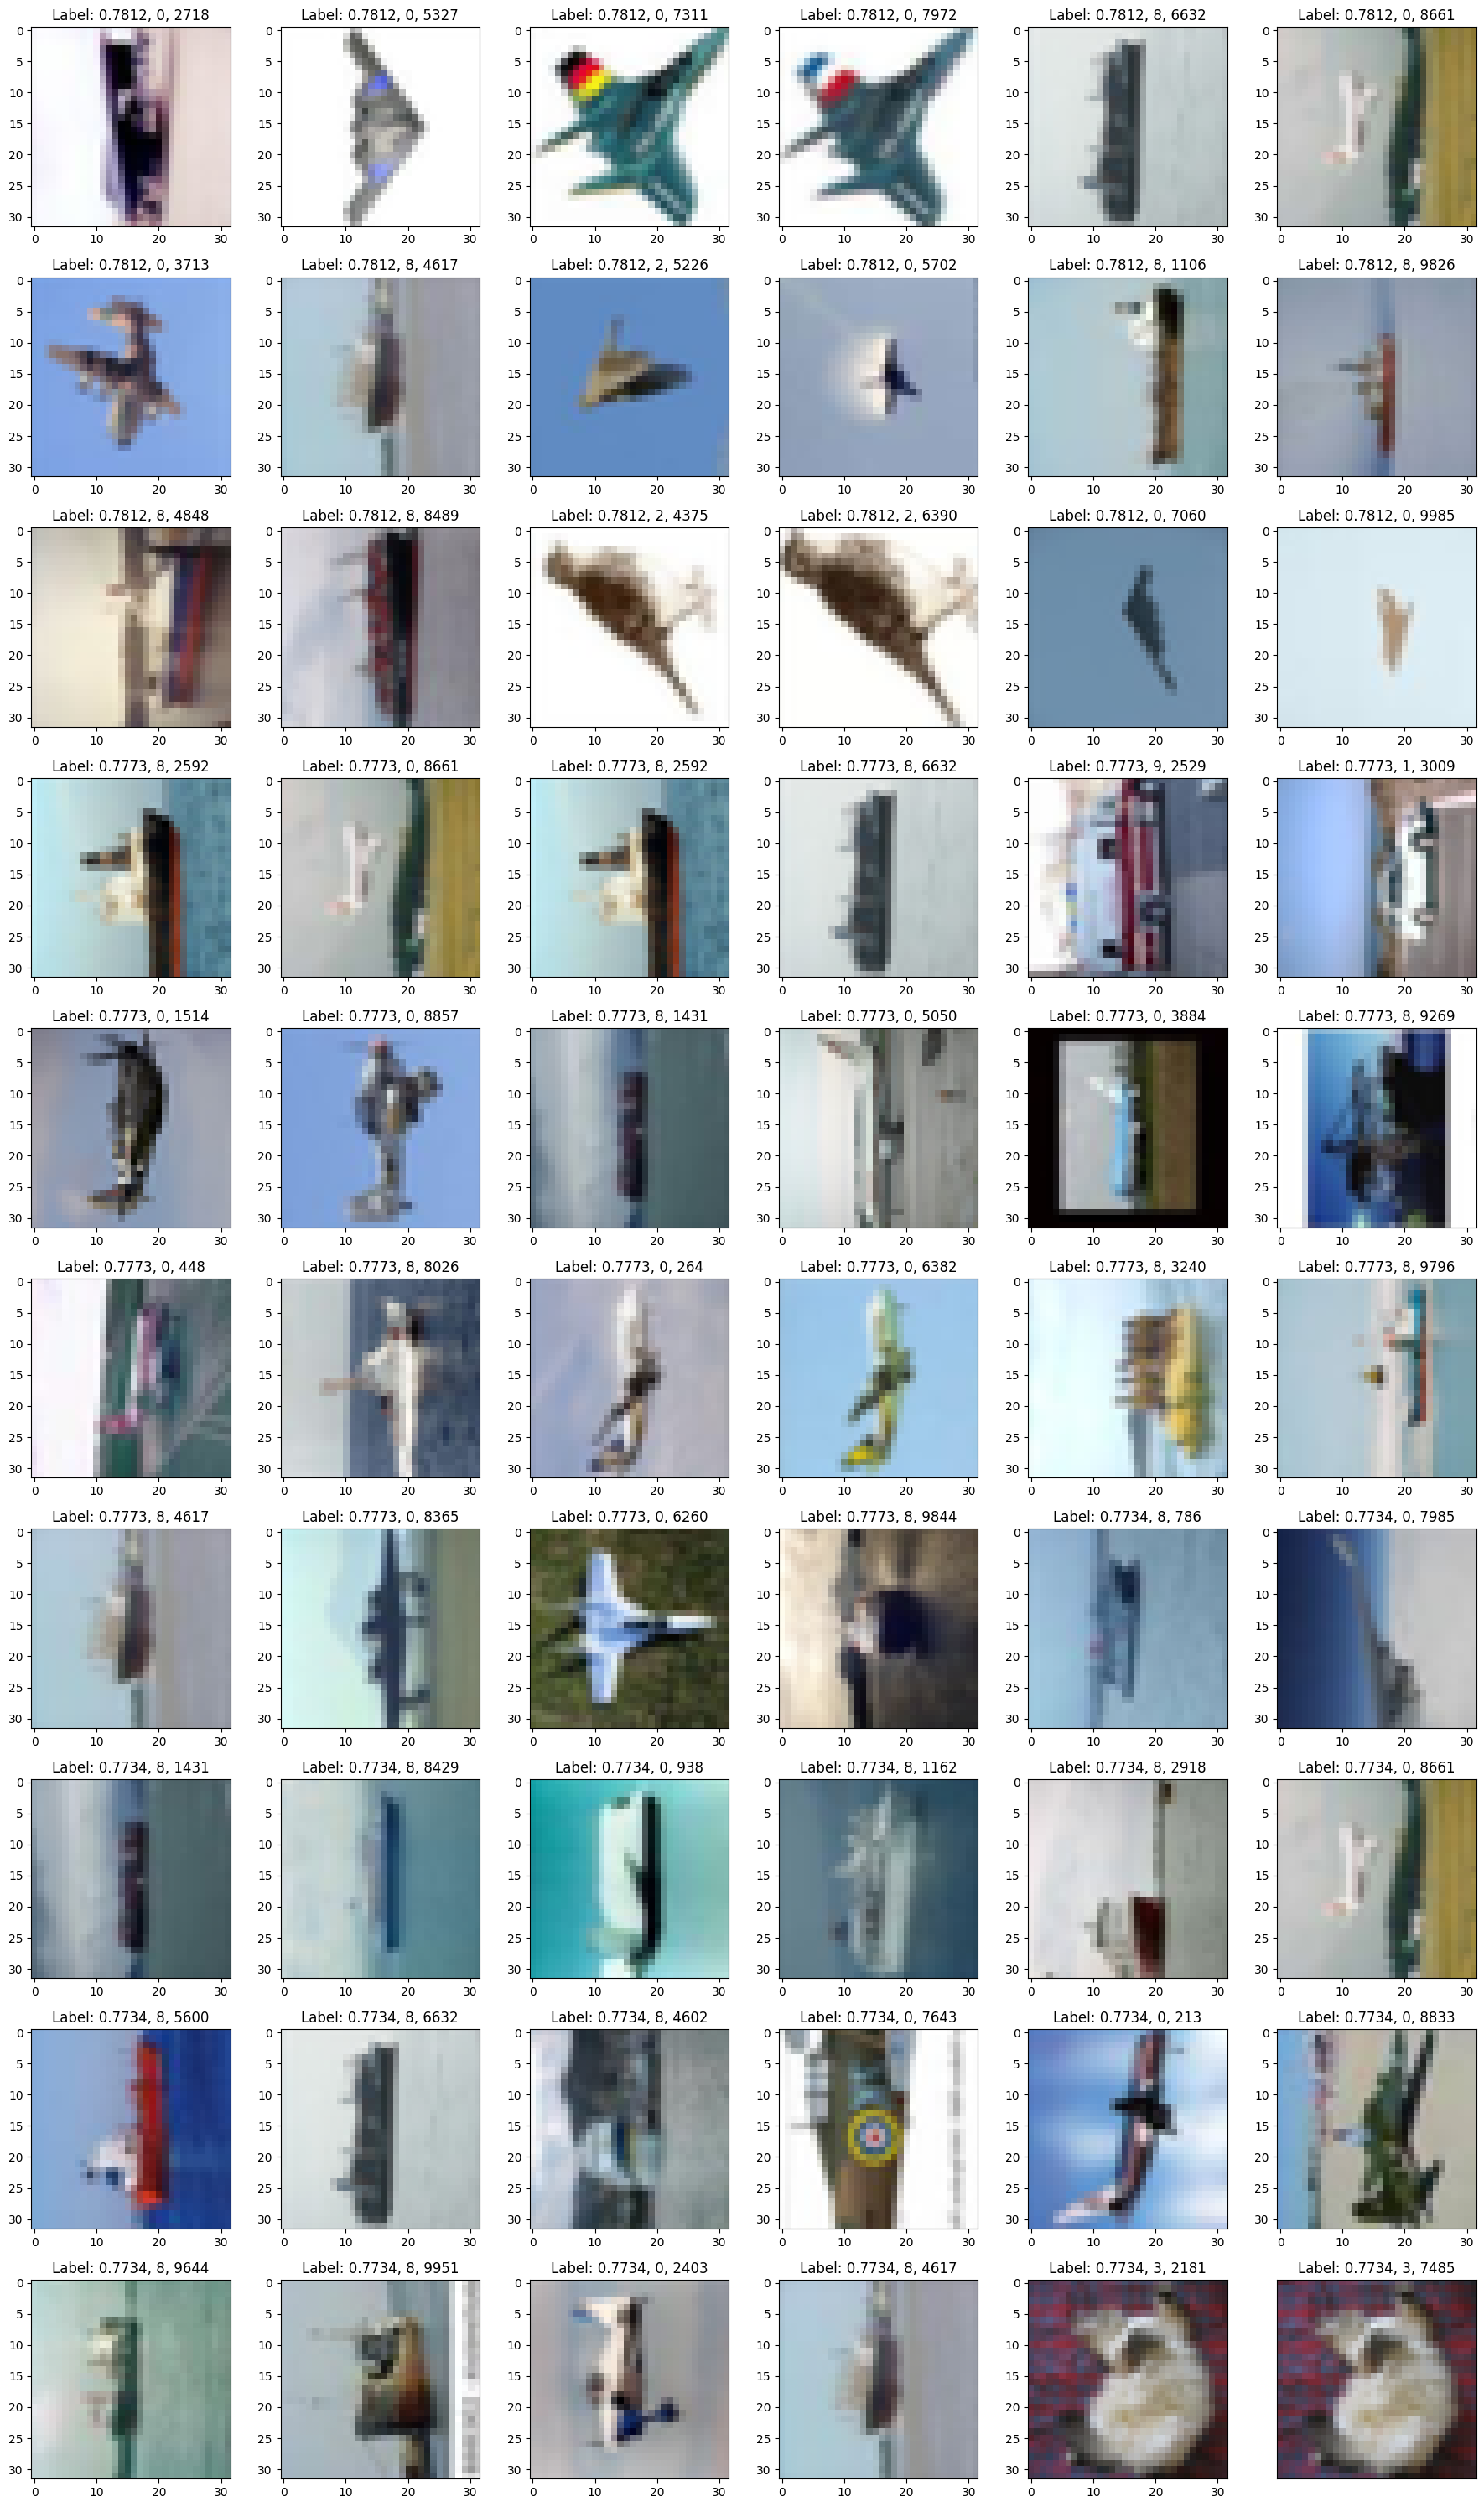

In [416]:
num_row = 10
num_col = 6

idx_start = 60;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[duplicates[i//2 + idx_start][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][0]]}, {duplicates[i//2 + idx_start][0]}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(images[duplicates[i//2 + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][1]]}, {duplicates[i//2 + idx_start][1]}""")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

#### Calculate MAP

In [324]:
from torcheval.metrics.functional import multiclass_auprc

In [504]:
print( len(duplicates) )

withoutLastElements = 577600

sumTrueDuplicates = 0
# same classes vs total 
for i in range( len(duplicates) - withoutLastElements ):
    #print(labels[duplicates[i][0]])
    #print(labels[duplicates[i][1]])
    if labels[duplicates[i][0]] == labels[duplicates[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates) - withoutLastElements )
print(acc)

577884
True duplicates:  109
All duplicates:  284
0.38380281690140844


In [328]:
#To write

In [332]:
#https://stackoverflow.com/questions/68610362/how-are-detect-and-compute-different-from-detectandcompute
#https://stackoverflow.com/questions/55313610/importerror-libgl-so-1-cannot-open-shared-object-file-no-such-file-or-directo
#https://ieeexplore.ieee.org/document/7043862
#https://pyimagesearch.com/2021/03/22/opencv-template-matching-cv2-matchtemplate/
#https://stackoverflow.com/questions/71514124/find-near-duplicate-and-faked-images
#https://neptune.ai/blog/object-detection-algorithms-and-libraries
#https://charlielehman.github.io/post/weak-segmentation-cifar10/

#### Metody Porównywania


In [419]:
# https://medium.com/@datamonsters/a-quick-overview-of-methods-to-measure-the-similarity-between-images-f907166694ee
# pshr method to compare
# https://www.linkedin.com/pulse/how-can-we-compare-two-images-python-pranav-kshirsagar-sxnkf
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
# frechet distance ???

### LSH with SHASH

In [447]:
from typing import List, Dict, Tuple

class LSH3:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):  # shingels
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np_only_edges(image.T, self.hash_size)
            self.signatures[idx] = np.packbits(signature.astype(np.uint8))
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            
    

In [451]:
import time

start = time.time()

lsh = LSH3(16, 16)
shingels = lsh.compute_hash(images)
pairs = lsh.compute_candidate()
duplicates = lsh.check_candidate(pairs,0.70)

end = time.time()
print( "time: ", end - start )

time:  7.286614894866943


In [452]:
from torcheval.metrics.functional import multiclass_auprc

In [458]:
print( len(duplicates) )

withoutLastElements = 200

sumTrueDuplicates = 0
# same classes vs total 
for i in range( len(duplicates) - withoutLastElements ):
    #print(labels[duplicates[i][0]])
    #print(labels[duplicates[i][1]])
    if labels[duplicates[i][0]] == labels[duplicates[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates) - withoutLastElements )
print(acc)

483
True duplicates:  123
All duplicates:  283
0.43462897526501765


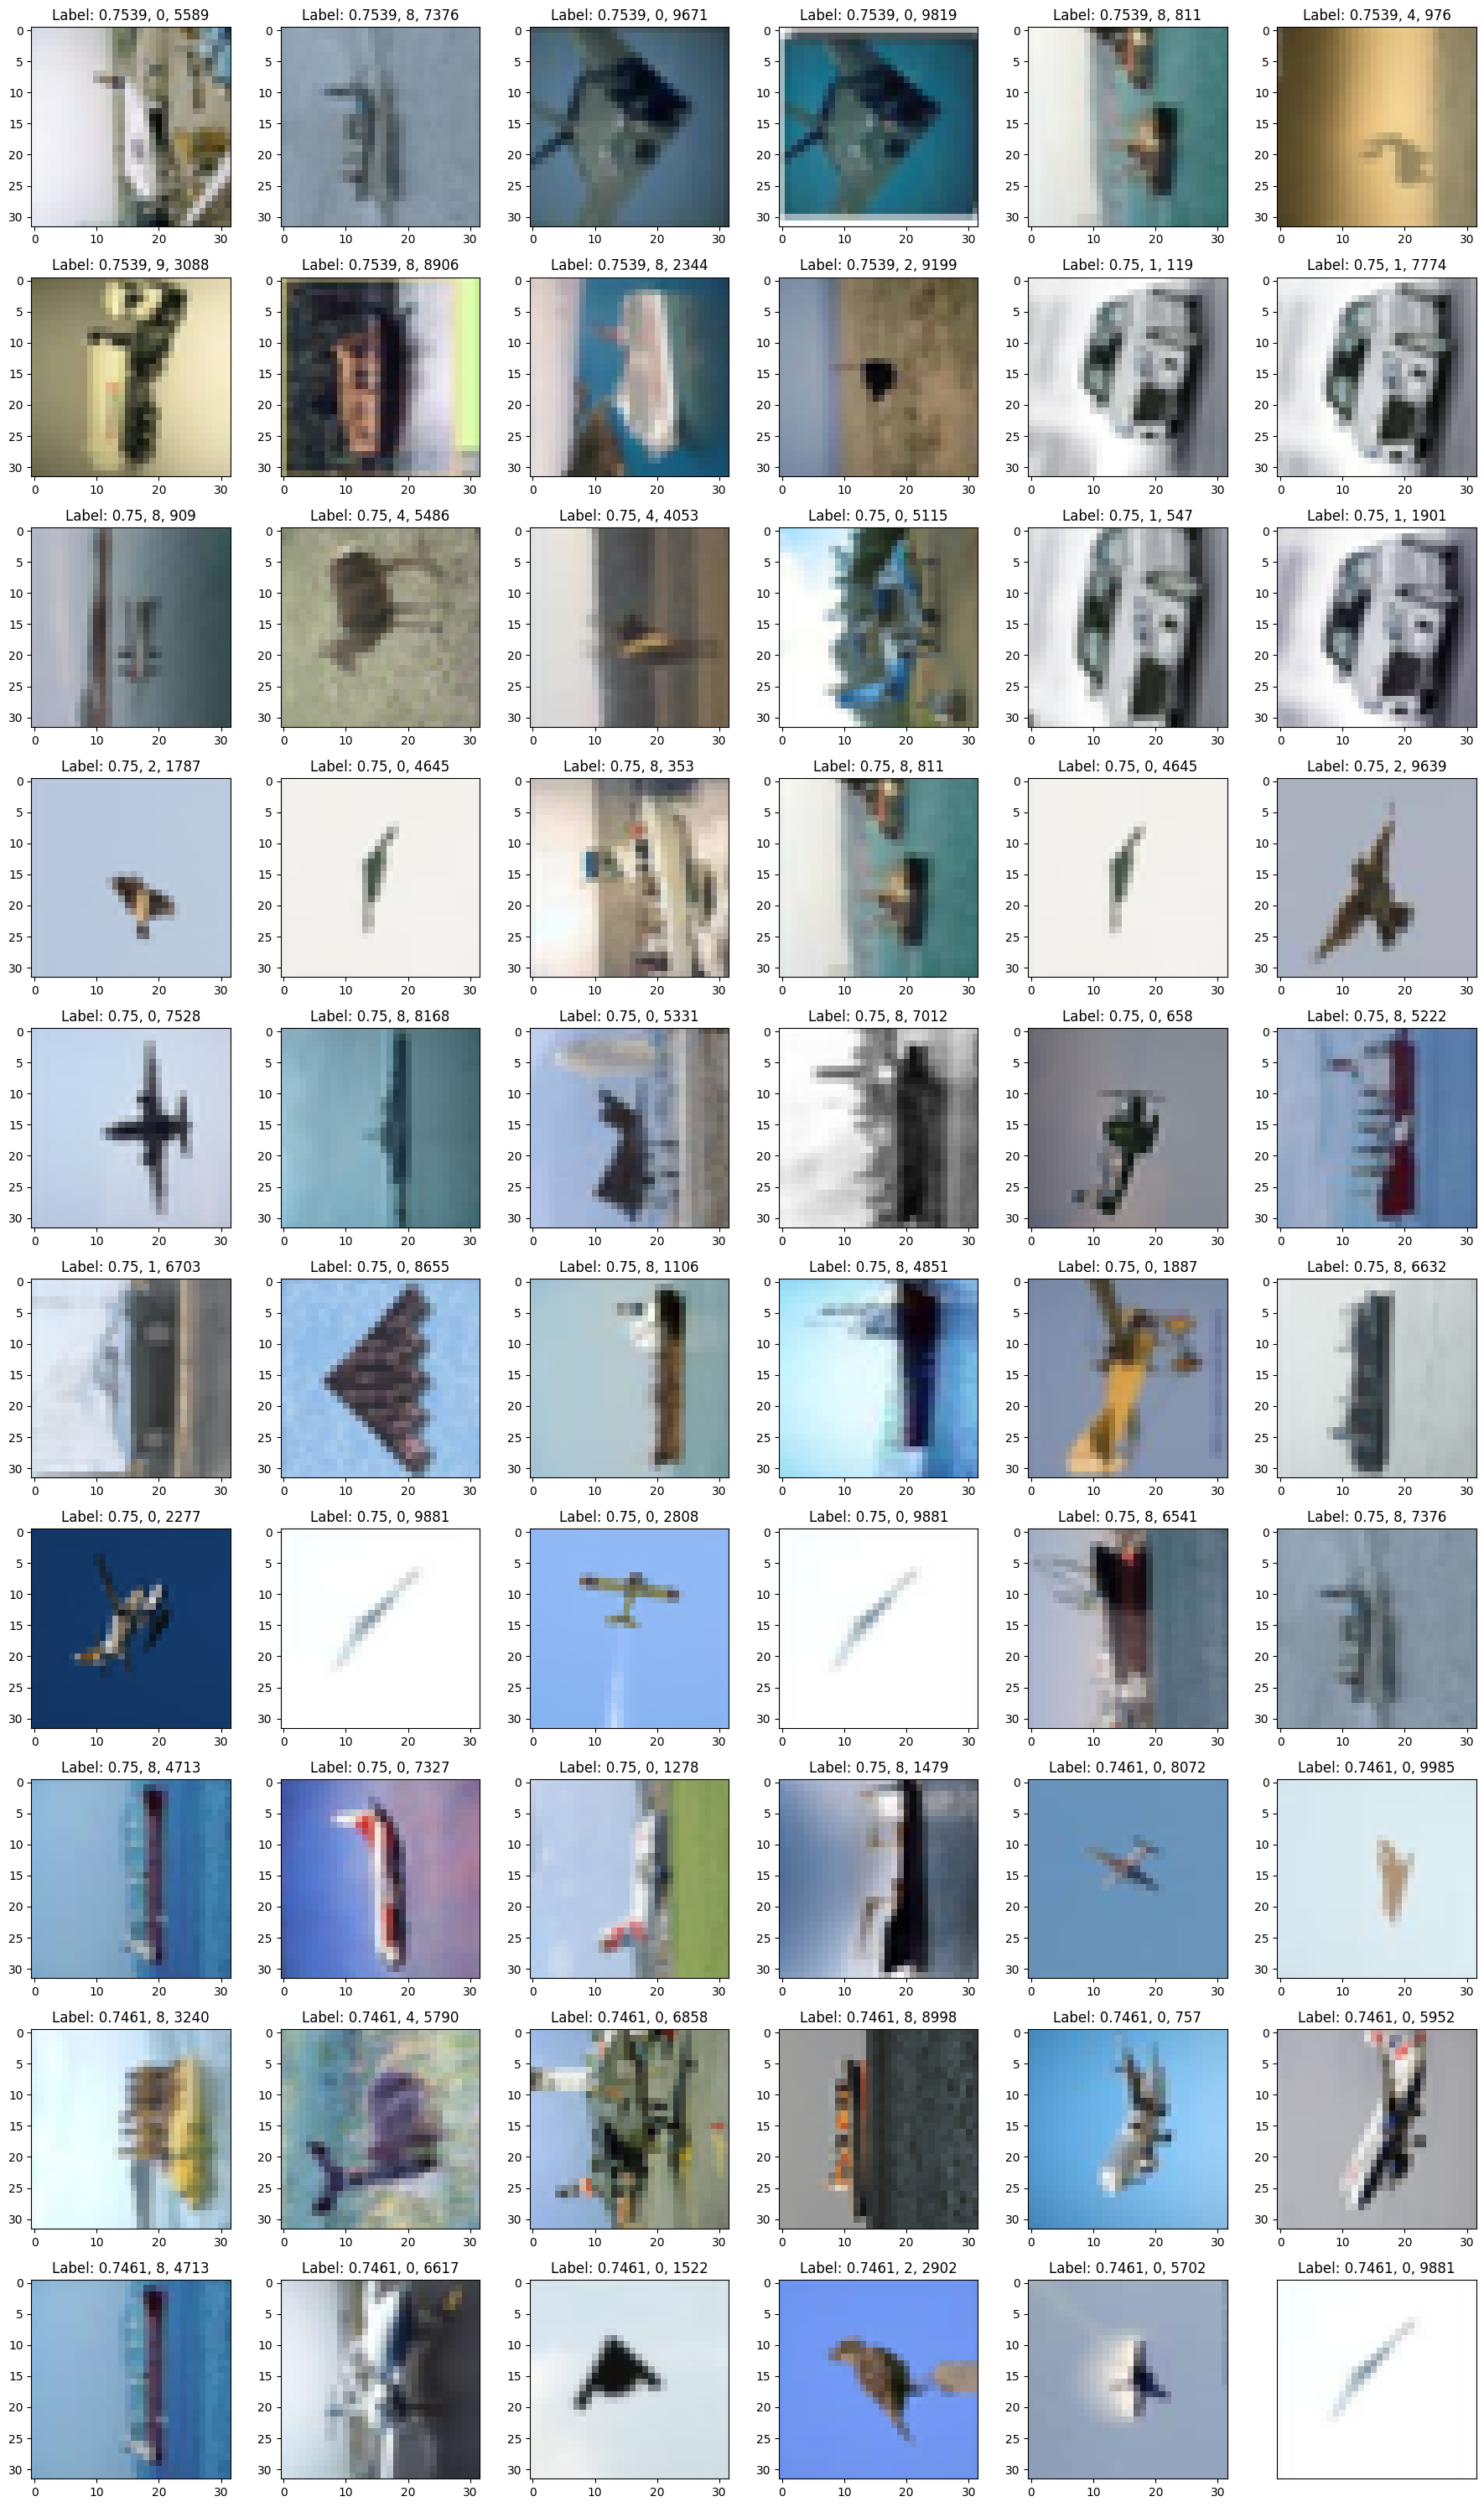

In [460]:
num_row = 10
num_col = 6

idx_start = 60;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[duplicates[i//2 + idx_start][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][0]]}, {duplicates[i//2 + idx_start][0]}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(images[duplicates[i//2 + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][1]]}, {duplicates[i//2 + idx_start][1]}""")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [461]:
## double verification....